In [2]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders import LeaveOneOutEncoder

# Import supervised model types here:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# define where to find the data
path = "data/Video_Games_Sales_as_at_22_Dec_2016.csv"

In [3]:
def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

<IPython.core.display.Javascript object>

## Data From: Kaggle:
## Video Game Sales and Ratings
### Video game sales data from VGChartz with corresponding ratings from Metacritic
### Kendall Gillies,  Rush Kirubi

In [4]:
df = pd.read_csv(path)  # move data into a pandas dataframe
df.head()  # preview the top five rows

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

* Observe percentage of missing data per column.
* Drop rows with missing values.

In [5]:
df.isna().mean().sort_values(ascending=False)

User_Count         0.546025
User_Score         0.546025
Critic_Count       0.513308
Critic_Score       0.513308
Rating             0.404869
Developer          0.396136
Year_of_Release    0.016089
Publisher          0.003230
Genre              0.000120
Name               0.000120
Global_Sales       0.000000
Other_Sales        0.000000
JP_Sales           0.000000
EU_Sales           0.000000
NA_Sales           0.000000
Platform           0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [6]:
notnone = df["User_Count"].isna()
df = df.iloc[~notnone.values]

<IPython.core.display.Javascript object>

In [7]:
df.shape

(7590, 16)

<IPython.core.display.Javascript object>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7590 entries, 0 to 16709
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             7590 non-null   object 
 1   Platform         7590 non-null   object 
 2   Year_of_Release  7463 non-null   float64
 3   Genre            7590 non-null   object 
 4   Publisher        7584 non-null   object 
 5   NA_Sales         7590 non-null   float64
 6   EU_Sales         7590 non-null   float64
 7   JP_Sales         7590 non-null   float64
 8   Other_Sales      7590 non-null   float64
 9   Global_Sales     7590 non-null   float64
 10  Critic_Score     7017 non-null   float64
 11  Critic_Count     7017 non-null   float64
 12  User_Score       7590 non-null   float64
 13  User_Count       7590 non-null   float64
 14  Developer        7579 non-null   object 
 15  Rating           7504 non-null   object 
dtypes: float64(10), object(6)
memory usage: 1008.0+ KB


<IPython.core.display.Javascript object>

In [10]:
df.isna().mean().sort_values(ascending=False)

Critic_Count       0.075494
Critic_Score       0.075494
Year_of_Release    0.016733
Rating             0.011331
Developer          0.001449
Publisher          0.000791
User_Count         0.000000
User_Score         0.000000
Global_Sales       0.000000
Other_Sales        0.000000
JP_Sales           0.000000
EU_Sales           0.000000
NA_Sales           0.000000
Genre              0.000000
Platform           0.000000
Name               0.000000
dtype: float64

<IPython.core.display.Javascript object>

In [11]:
df = df.dropna(axis=0)

<IPython.core.display.Javascript object>

In [12]:
df = df.astype({"Year_of_Release": "int64"})

<IPython.core.display.Javascript object>

In [13]:
df_NA = df.drop(columns=["Global_Sales", "EU_Sales", "JP_Sales", "Other_Sales"])
df_Global = df.drop(columns=["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"])

<IPython.core.display.Javascript object>

In [14]:
df_NA_num = df_NA.select_dtypes(include=["float64", "int64"])
df_Global_num = df_Global.select_dtypes(include=["float64", "int64"])

<IPython.core.display.Javascript object>

In [15]:
df_NA_num = df_NA_num.assign(log_NA_sales=np.log1p(df.NA_Sales))
df_Global_num = df_Global_num.assign(log_Global_sales=np.log1p(df.Global_Sales))

<IPython.core.display.Javascript object>

In [16]:
df_NA_num.columns

Index(['Year_of_Release', 'NA_Sales', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'log_NA_sales'],
      dtype='object')

<IPython.core.display.Javascript object>

In [17]:
df_NA_num_corr = df_NA_num.corr()["log_NA_sales"][:-1]
golden_feature_list = df_NA_num_corr[abs(df_NA_num_corr) > 0.2].sort_values(
    ascending=False
)
print(
    "There is {} strongly correlated values with a column:\n{}".format(
        len(golden_feature_list), golden_feature_list
    )
)

There is 4 strongly correlated values with a column:
NA_Sales        0.832614
Critic_Count    0.391210
Critic_Score    0.344018
User_Count      0.286709
Name: log_NA_sales, dtype: float64


<IPython.core.display.Javascript object>

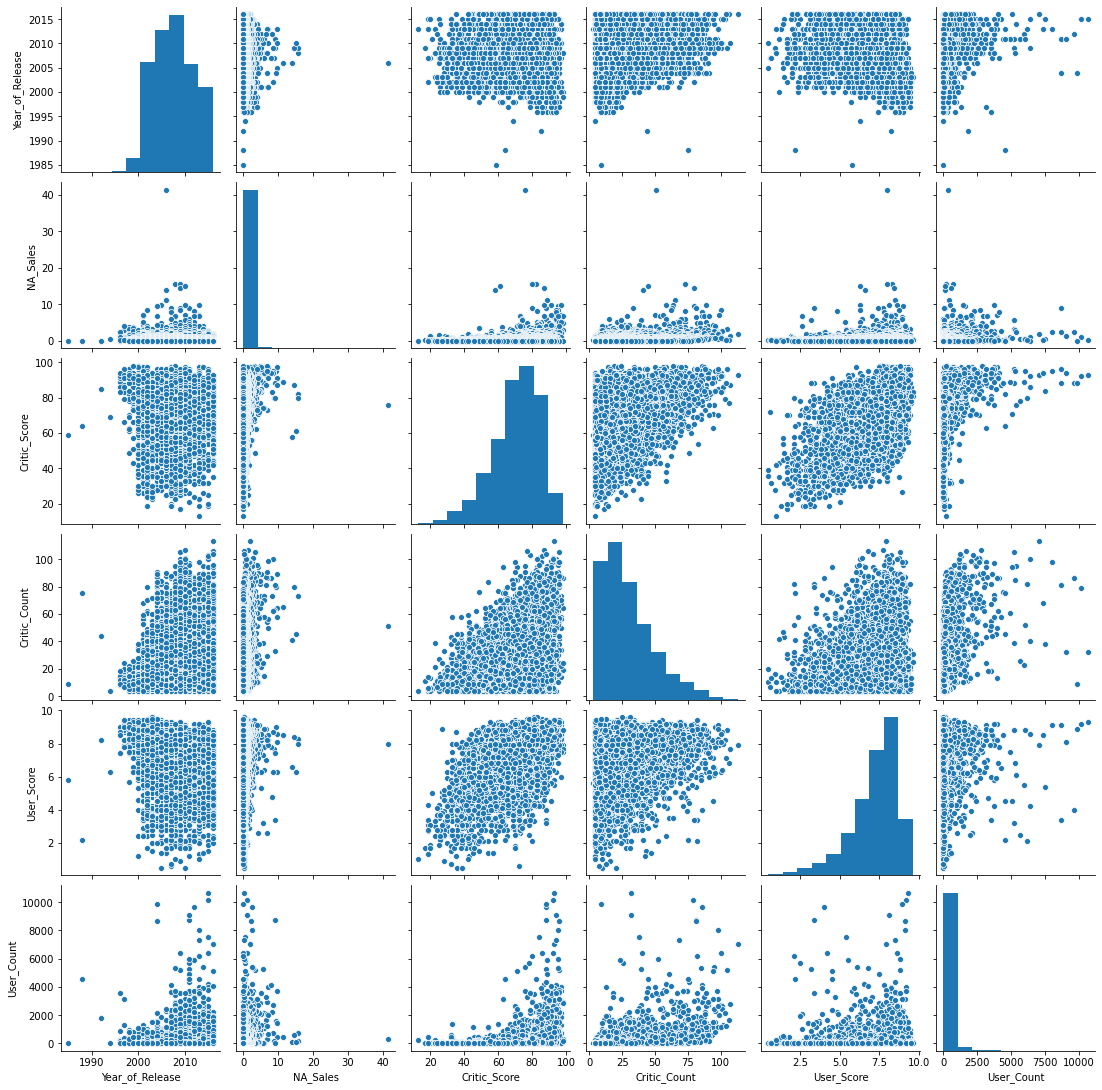

<IPython.core.display.Javascript object>

In [18]:
sns.pairplot(data=df_NA)
plt.show()

In [19]:
df_Global_num_corr = df_Global_num.corr()["log_Global_sales"][:-1]  # -1 if 'a column'
golden_feature_list = df_Global_num_corr[abs(df_Global_num_corr) > 0.2].sort_values(
    ascending=False
)
print(
    "There is {} strongly correlated values with a column:\n{}".format(
        len(golden_feature_list), golden_feature_list
    )
)

There is 4 strongly correlated values with a column:
Global_Sales    0.783157
Critic_Count    0.434604
Critic_Score    0.381688
User_Count      0.330166
Name: log_Global_sales, dtype: float64


<IPython.core.display.Javascript object>

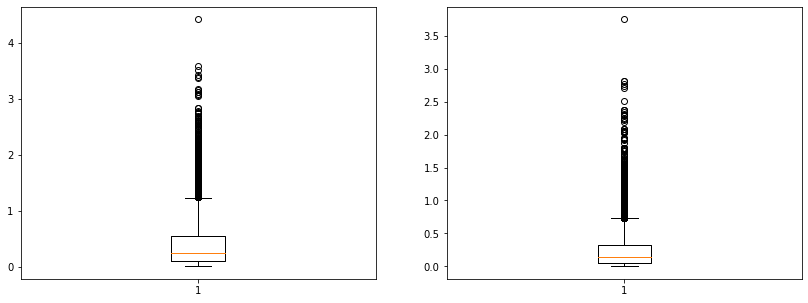

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.boxplot(np.log1p(df["Global_Sales"]))
plt.subplot(122)
plt.boxplot(np.log1p(df["NA_Sales"]))

plt.show()

In [21]:
df = df.assign(log_NA_Sales=np.log1p(df.NA_Sales))
df = df.assign(log_Global_Sales=np.log1p(df.Global_Sales))

<IPython.core.display.Javascript object>

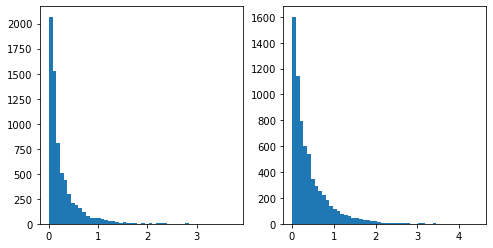

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.hist(x=df["log_NA_Sales"], bins=50)
plt.subplot(122)
plt.hist(x=df["log_Global_Sales"], bins=50)
plt.show()


In [23]:
df["Critic_Combo"] = df["Critic_Count"] * df["Critic_Score"]
df["User_Combo"] = df["User_Count"] * df["User_Score"]

<IPython.core.display.Javascript object>

In [24]:
wantedRatings = (
    (df.Rating == "E") | (df.Rating == "M") | (df.Rating == "T") | (df.Rating == "E10+")
)
df = df.iloc[wantedRatings.values]

<IPython.core.display.Javascript object>

In [25]:
perc_90, perc_95, perc_97, perc_99 = np.percentile(df["Global_Sales"], [90, 95, 97, 99])
print(perc_90, perc_95, perc_97, perc_99)

1.7 2.899499999999998 3.9958999999999927 7.1678999999999995


<IPython.core.display.Javascript object>

In [26]:
in_perc_90 = df.Global_Sales <= perc_90
in_perc_95 = df.Global_Sales <= perc_95
in_perc_97 = df.Global_Sales <= perc_97
in_perc_99 = df.Global_Sales <= perc_99

df_90_G = df.iloc[in_perc_90.values]
df_95_G = df.iloc[in_perc_95.values]
df_97_G = df.iloc[in_perc_97.values]
df_99_G = df.iloc[in_perc_99.values]


<IPython.core.display.Javascript object>

In [27]:
perc_90, perc_95, perc_97, perc_99 = np.percentile(df["NA_Sales"], [90, 95, 97, 99])

in_perc_90 = df.NA_Sales <= perc_90
in_perc_95 = df.NA_Sales <= perc_95
in_perc_97 = df.NA_Sales <= perc_97
in_perc_99 = df.NA_Sales <= perc_99

df_90 = df.iloc[in_perc_90.values]
df_95 = df.iloc[in_perc_95.values]
df_97 = df.iloc[in_perc_97.values]
df_99 = df.iloc[in_perc_99.values]


<IPython.core.display.Javascript object>

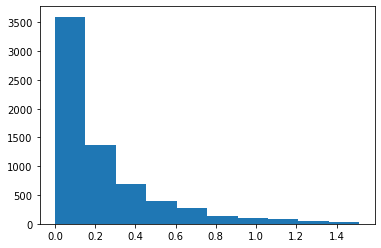

<IPython.core.display.Javascript object>

In [28]:
plt.hist(x=df_99["log_NA_Sales"])
plt.show()

In [52]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating',
       'log_NA_Sales', 'log_Global_Sales', 'Critic_Combo', 'User_Combo'],
      dtype='object')

<IPython.core.display.Javascript object>

In [93]:
drop_cols = [
    "Name",
    "NA_Sales",
    "Global_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
    "Global_Sales",
    "Publisher",
    "Developer",
    #     "log_Global_Sales",
    "log_NA_Sales",
]

X = df_99_G.drop(columns=drop_cols)
y = df_99_G["log_Global_Sales"]

<IPython.core.display.Javascript object>

In [75]:
drop_cols = [
    "Name",
    "NA_Sales",
    "Global_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
    "Global_Sales",
    "Publisher",
    "Developer",
    "log_Global_Sales",
    #     "log_NA_Sales",
]

X = df_99.drop(columns=drop_cols)
y = df_99["log_NA_Sales"]

<IPython.core.display.Javascript object>

In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X.Rating
)

<IPython.core.display.Javascript object>

In [77]:
num_cols = [
    "Year_of_Release",
    "User_Count",
    "User_Score",
    "User_Combo",
    "Critic_Count",
    "Critic_Score",
    "Critic_Combo",
]
bin_cols = []
cat_cols = ["Platform", "Genre", "Rating"]
drop_cats = ["PS4", "Sports", "E"]

<IPython.core.display.Javascript object>

## XGBoost Regression Model

In [78]:
# fmt: off
preprocessing = ColumnTransformer([
    ("scale", StandardScaler(), num_cols),
    ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols),
], remainder="passthrough")

<IPython.core.display.Javascript object>

In [79]:
# fmt: off
params = {
#     "model__subsample": [ 0.65, 0.75, .8, 1],
    "model__subsample": [0.4, 0.5, 0.6, 1.0],
#     "model__colsample_bytree": [ 0.75, 0.85, .90, 1],
    "model__colsample_bytree": [0.25 , 0.5, 0.75, 1.0],
#     "model__max_depth": [7, 8, 9, 10],
    "model__max_depth": [7, 10, 12],
}
n_trees = 100
learning_rate = 2 / n_trees

<IPython.core.display.Javascript object>

In [80]:
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", XGBRegressor(n_estimators=n_trees, learning_rate=learning_rate)),
        #     ("model", Ridge())
        #     ('model', ElasticNet())
    ]
)

<IPython.core.display.Javascript object>

In [81]:
pipeline_cv = GridSearchCV(pipeline, params, verbose=1, n_jobs=-1, cv=2)

<IPython.core.display.Javascript object>

In [95]:
pipeline_cv.fit(X_train, y_train)

print(f"Train Score: {pipeline_cv.score(X_train, y_train)}")
print(f"Test Score: {pipeline_cv.score(X_test, y_test)}")

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.0min finished


Train Score: 0.9803727197953137
Test Score: 0.9795348922284542


<IPython.core.display.Javascript object>

99th percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': 1,'model__max_depth': 10,'model__subsample': 0.75}
Train Score: 0.7091890031893382
Test Score: 0.5005489069929983

99th percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': .85,'model__max_depth': 9,'model__subsample': 0.75}
Train Score: 0.6709216221163665
Test Score: 0.5014700261290725

99th percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': .85,'model__max_depth': 8,'model__subsample': 0.75}
Train Score: 0.6343650050335347
Test Score: 0.5011677336836367





In [84]:
pipeline_cv.best_params_

{'model__colsample_bytree': 1.0,
 'model__max_depth': 7,
 'model__subsample': 1.0}

<IPython.core.display.Javascript object>

In [96]:
y_pred = pipeline_cv.predict(X_test)
y_pred_exp = np.exp(y_pred)-1
y_test_exp = np.exp(y_test)-1
MAE = np.mean(abs(y_test_exp-y_pred_exp))
MAPE = np.mean(abs((y_test_exp-y_pred_exp)/y_test_exp))
print(MAE)
print(MAPE)


0.08724079306438003
0.5447388684993854


<IPython.core.display.Javascript object>

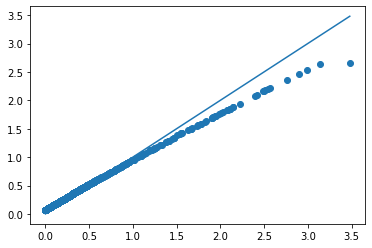

<IPython.core.display.Javascript object>

In [424]:
plt.scatter(y_test_exp, y_pred_exp)
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()])
plt.show()

## Lasso Model

In [86]:
preprocessing.fit(X_train)

X_train_trans = preprocessing.transform(X_train)
X_test_trans = preprocessing.transform(X_test)

<IPython.core.display.Javascript object>

In [87]:
grid = {"alpha": [0.00000001, 0.0000001, 0.000001, 0.00001]}

lasso_cv = GridSearchCV(Lasso(), grid, verbose=1, cv=5, n_jobs=-1)
lasso_cv.fit(X_train_trans, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")
lasso_cv.best_estimator_.coef_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


selected alpha: 1e-05


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.4s finished


array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -4.13527202e-05,
       -1.43375546e-03, -2.93944675e-04,  1.58686632e-03, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  9.99744655e-01])

<IPython.core.display.Javascript object>

In [88]:
print(f"Train Score: {lasso_cv.score(X_train_trans, y_train)}")
print(f"Test Score: {lasso_cv.score(X_test_trans, y_test)}")

Train Score: 0.999999298182564
Test Score: 0.9999991756880717


<IPython.core.display.Javascript object>

In [89]:
y_pred = lasso_cv.predict(X_test_trans)
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)
MAE = np.mean(abs(y_test_exp - y_pred_exp))
MAPE = np.mean(abs((y_test_exp - y_pred_exp) / y_test_exp))
print(MAE)
print(MAPE)

0.0002164653833284115
0.00015626861755991975


<IPython.core.display.Javascript object>

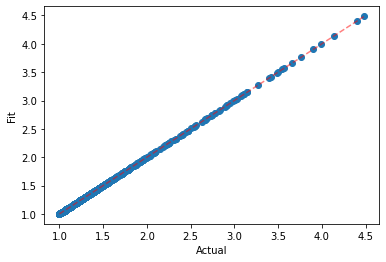

<IPython.core.display.Javascript object>

In [563]:
line_pts = [y_test_exp.min(), y_test_exp.max()]
plt.scatter(y_test_exp, y_pred_exp)
plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Fit")
plt.show()

## Elastic Net Model

In [90]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1], "l1_ratio": [0.1, 0.5, 0.75, 1]}
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train_trans, y_train)

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


selected alpha: 0.0001
selected l1_ratio: 1


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    4.5s finished


array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.40660746e-05, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  9.98606897e-01])

<IPython.core.display.Javascript object>

In [91]:
print(f"Train Score: {elasticnet_cv.score(X_train_trans, y_train)}")
print(f"Test Score: {elasticnet_cv.score(X_test_trans, y_test)}")



Train Score: 0.9999982775925952
Test Score: 0.9999982960989167


<IPython.core.display.Javascript object>

In [92]:
y_pred = lasso_cv.predict(X_test_trans)
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)
MAE = np.mean(abs(y_test_exp - y_pred_exp))
MAPE = np.mean(abs((y_test_exp - y_pred_exp) / y_test_exp))
print(MAE)
print(MAPE)

0.0002164653833284115
0.00015626861755991975


<IPython.core.display.Javascript object>

## KNN model

In [ ]:
pipeline = Pipeline([("preprocessing", preprocessing), ("knn", KNeighborsRegressor())])

In [578]:
ks = np.arange(1, 100, 2)
rmses = []

for k in ks:
    pipeline.named_steps["knn"].n_neighbors = k
    neg_rmses = cross_val_score(
        pipeline, X_train, y_train, scoring="neg_root_mean_squared_error"
    )
    avg_rmse = np.mean(-neg_rmses)
    rmses.append(avg_rmse)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

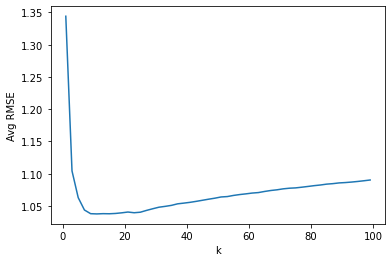

<IPython.core.display.Javascript object>

In [351]:
plt.plot(ks, rmses)
plt.xlabel("k")
plt.ylabel("Avg RMSE")
plt.show()

In [352]:
grid = {"knn__n_neighbors": np.arange(1, 100, 4)}
model = GridSearchCV(pipeline, grid)
model.fit(X_train, y_train)

model.best_params_

{'knn__n_neighbors': 13}

<IPython.core.display.Javascript object>

In [353]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


0.542524820712744
0.42749747745141986


<IPython.core.display.Javascript object>

In [360]:
y_pred = model.predict(X_test)
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)
MAE = np.mean(abs(y_test_exp - y_pred_exp))
MAPE = np.mean(abs((y_test_exp - y_pred_exp) / y_test_exp))
print(MAE)
print(MAPE)

0.47525437707799123
1.3970887441594544


<IPython.core.display.Javascript object>

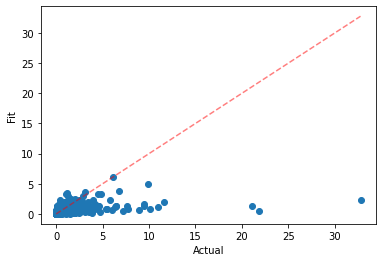

<IPython.core.display.Javascript object>

In [367]:
line_pts = [y_test_exp.min(), y_test_exp.max()]
plt.scatter(y_test_exp, y_pred_exp)
plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Fit")
plt.show()